# Assignment 3
## Training a neural named entity recognition (NER) tagger 

In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using LSTM.



The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the [CoNLL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/): 

- [Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

- [Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

- [Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you will see, the annotated texts are labeled according to the `IOB` annotation scheme, for 3 entity types: Person, Organization, Location.


NER schemes:  

> `IO`: is the simplest scheme that can be applied to this task. In this scheme, each token from the dataset is assigned one of two tags: an inside tag (I) and an outside tag (O). The I tag is for named entities, whereas the O tag is for normal words. This scheme has a limitation, as it cannot correctly encode consecutive entities of the same type.

> **`IOB`: This scheme is also referred to in the literature as BIO and has been adopted by the Conference on Computational Natural Language Learning (CoNLL) [1]. It assigns a tag to each word in the text, determining whether it is the beginning (B) of a known named entity, inside (I) it, or outside (O) of any known named entities.**

> `IOE`: This scheme works nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

> `IOBES`: An alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the beginning (B), inside (I), end (E), and outside (O) of a named entity. It also labels single-token entities with the tag S.

> `BI`: This scheme tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O.

> `IE`: This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.

> `BIES`: This scheme encodes the entities similar to IOBES. In addition, it also encodes the non-entity words using the same method. It uses B-O to tag the beginning of non-entity words, I-O to tag the inside of non-entity words, and S-O for single non-entity tokens that exist between two entities.


As always, make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.
<br>
<br>  

---

<br>

All additional packages:

In [2]:
# !pip install --q

All imports:
(You may add/change)

In [3]:
# general
import os
import copy
import random
import warnings
from typing import List,Tuple
from collections import defaultdict
import requests
import re

# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report


set warnings filter to ignore:

In [4]:
import warnings
warnings.filterwarnings('ignore')

Set random SEEDs:

In [5]:
RANDOM_SEED = 42

# Set the random seed for Python to SEED
random.seed(RANDOM_SEED)

# Set the random seed for numpy
np.random.seed(RANDOM_SEED)

# Set the random seed for torch to SEED
# To Do

Set GPU:

In [6]:
# make sure you're using a GPU

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Task 1:
Write a function for reading the data from a single file (of the ones that are provided above).   
- The function recieves a filepath 
- The funtion encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags. 
- Each list pair will be added to a general list (data), which will be returned back from the function.

Example output:
```
[
  (['At','Trent','Bridge',':'],['O','B-LOC','I-LOC ','O']),
  ([...],[...]),
  ...
]
```

In [7]:
def read_data(filepath: str) -> List[Tuple[List[str], List[str]]]:
    data = []
    response = requests.get(filepath)
    sentences = re.split(r'\n\s*\n', response.text)[:-1]

    for sentence in sentences:
      sentence = sentence.split()
      n = len(sentence)
      tokens = sentence[:n:2]
      tags = sentence[1:n:2]
      data.append((tokens, tags))
        
    print(f"num of sentences: {len(data)}")
    return data

# GitHub
train_link = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_train.txt'
dev_link   = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_dev.txt'
test_link  = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_test.txt'

# Google-Drive
# train_link = 'https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing'
# dev_link   = 'https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing'
# test_link  = 'https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing'


train = read_data(train_link)
dev = read_data(dev_link)
test = read_data(test_link)

num of sentences: 1750
num of sentences: 250
num of sentences: 500


## Task 2:

The following Vocab class can be served as a dictionary that maps words and tags into Ids.   
The UNK_TOKEN should be used for words that are not part of the training data.

Note: you may change the Vocab class

In [8]:
# To DO
UNK_TOKEN = 1
WORD_PAD_TOKEN = 0
TAG_PAD_TOKEN = -1

class Vocab:
    def __init__(self, train:List[Tuple[List[str],List[str]]]):
        self.word2id = {"__unk__": UNK_TOKEN}
        self.id2word = {UNK_TOKEN: "__unk__"}

        self.tag2id = None
        self.id2tag = None
        self.tag_wights = None

        # initilize based on train dataset
        self._init_tags(train)
        self._init_words(train)

        # TODO: create class weight sequnece

    @property
    def n_words(self):
        return len(self.word2id)
    
    @property
    def n_tags(self):
        return len(self.tag2id)
    
    def _init_tags(self, train: List[Tuple[List[str], List[str]]]):
        tags = []
        for _, tag_seq in train:
          tags.extend(tag_seq)
        tags_df = pd.DataFrame(np.unique(np.array(tags), return_counts=True)).T
        tags_df.columns = ['tag', 'count']
        self.id2tag = tags_df['tag'].to_dict()
        self.tag2id = {tag: i for i, tag in self.id2tag.items()}
        self.tag_weights = (tags_df['count'].sum() / (len(tags_df) * tags_df['count'])).values.astype(float)

      
    def _init_words(self, train: List[Tuple[List[str], List[str]]]):
        words = set()
        for word_seq, _ in train:
            words.update(word_seq)
        self.word2id.update({word: i+2 for i, word in enumerate(words)})
        self.id2word.update({i: word for word, i in self.word2id.items()})

    def get_ids(self, data: List[Tuple[List[str], List[str]]]):
      ids = []
      for words, tags in data:
        word_ids = self._get_words_ids(words)
        tag_ids = self._get_tags_ids(tags)
        ids.append((word_ids, tag_ids))
      return ids
    
    def _get_tags_ids(self, tags:List[str]) -> List[int]:
      return [self.tag2id[t] for t in tags]

    
    def _get_words_ids(self, words:List[str]) -> List[str|int]:
      return [self.word2id.get(w, UNK_TOKEN) for w in words]


# Testing - do not change
vcb = Vocab(train)
assert vcb.tag2id.keys() == {"O":0, "B-PER":1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4, "B-ORG": 5, "I-ORG": 6}.keys()
print(len(vcb.word2id))
# del vcb

7162


Write a function prepare_data that takes one of the [train, dev, test] and the Vocab instance, for converting each pair of (words,tags) to a pair of indexes.  

Each pair should be added to data_sequences, which will be returned back from the function.

Note: Vocabulary is based only on the train set.

In [9]:
def prepare_data(data, _vocab=None):
    if _vocab:
      return _vocab.get_ids(data)
    else:
      vocab = Vocab(data)
      return vocab.get_ids(data), vocab

train_sequences, vocab = prepare_data(train)
dev_sequences = prepare_data(dev, vocab)
test_sequences = prepare_data(test, vocab)

In [10]:
# TO DO
# Out of Vocabulary 
def count_oov_words(data, vocab):
    oov_count = 0
    for words, _ in data:
        oov_count += words.count(UNK_TOKEN)
    return oov_count

Print: how many OOV words are in the dev dataset? 

In [11]:
oov_count = count_oov_words(dev_sequences, vocab)
print(f"OOV count: {oov_count}")

OOV count: 638


Print: how many OOV words are in the test dataset? 

In [12]:
# TO DO
oov_count = count_oov_words(test_sequences, vocab)
print(f"OOV count: {oov_count}")

OOV count: 1368


<br><br><br><br><br><br>

## Task 3:

Write NERNet, a PyTorch Module for labeling words with NER tags. 

> `input_size`: the size of the vocabulary  
`embedding_size`: the size of the embeddings  
`hidden_size`: the LSTM hidden size  
`output_size`: the number tags we are predicting for  
`n_layers`: the number of layers we want to use in LSTM  
`directions`: could 1 or 2, indicating unidirectional or bidirectional LSTM, respectively  

<br>  

The input for your forward function should be a single sentence tensor.

*Note: the embeddings in this section are learned embedding. That means that you don't need to use pretrained embedding like the one used in class. You will use them in part 5.*

*Note: You may change the NERNet class.* 

In [26]:
from torch.nn.modules.activation import Softmax
# You may change the NERNet class.

class NERNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers, directions):
        super(NERNet, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size=hidden_size 
        self.output_size=output_size
        self.n_layers=n_layers
        self.directions=directions

        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=WORD_PAD_TOKEN)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, bidirectional=directions==2, batch_first=True)
        self.out = nn.Sequential(
            nn.Linear(directions*hidden_size, output_size),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, input_sentence):
        x = self.embedding(input_sentence)
        x, _ = self.lstm(x)
        output = self.out(x)
        return output
    
    @classmethod
    def from_pretrained_embeddings(cls, embeddings: nn.Embedding, hidden_size: int, output_size: int, n_layers: int, directions: int):
        model = cls(embeddings.num_embeddings, embeddings.embedding_dim, hidden_size, output_size, n_layers, directions)
        model.embedding = embeddings
        return model


Create a Dataloader for the training phase

In [14]:
from torch import LongTensor

class NERDataset(Dataset):
  def __init__(self, sequences: List[Tuple[List[str], List[str]]]):
    self._sequences = sequences

  def __len__(self):
    return len(self._sequences)

  def __getitem__(self, idx):
      words, tags = self._sequences[idx]
      return LongTensor(words), LongTensor(tags)

  @staticmethod
  def collate_fn(batch):
      words, tags = zip(*batch)
      words = nn.utils.rnn.pad_sequence(words, batch_first=True, padding_value=WORD_PAD_TOKEN)
      tags = nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=TAG_PAD_TOKEN)
      return words, tags


def prepare_data_loader(sequences, **kwargs):
  dataset = NERDataset(sequences)
  dataloader = DataLoader(dataset, collate_fn=NERDataset.collate_fn, **kwargs)
  return dataloader


dl_train  = prepare_data_loader(train_sequences , batch_size = 64, shuffle=True)
dl_dev    = prepare_data_loader(dev_sequences   , batch_size = 64)
dl_test   = prepare_data_loader(test_sequences  , batch_size = 64)

<br><br><br><br><br><br>

## Task 4:

Write a training loop, which takes a model (instance of NERNet), number of epochs to train on, and the train&dev datasets.  

The function will return the `loss` and `accuracy` durring training.  
(If you're using a different/additional metrics, return them too)

The loss is always CrossEntropyLoss and the optimizer is always Adam.
Make sure to use `tqdm` while iterating on `n_epochs`.


In [15]:
from typing import NamedTuple

class TaggerEvalOutputs(NamedTuple):
  accs: float = None
  precision: float = None
  recall: float = None
  f1: float = None

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from torch import FloatTensor

class Trainer:
    def __init__(self, model, train_loader, validation_loader, device):
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss(ignore_index=TAG_PAD_TOKEN, weight=FloatTensor(vocab.tag_weights)).to(device)
        self.optimizer = Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-4)
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.device = device


    def _train_epoch(self):
        self.model.train()
        epoch_losses = []
        accs = []
        epoch_loss = 0
        for batch_idx, (words, tags) in enumerate(self.train_loader):
            words, tags = words.to(self.device), tags.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(words)
            loss = self.criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
            loss.backward()
            epoch_losses.append(loss.item())
            self.optimizer.step()
            
            outputs[tags == TAG_PAD_TOKEN] = 0
            pred = outputs.argmax(-1)
            
            accs.append(self._calc_accuracy(pred, tags))

        return np.mean(epoch_losses), TaggerEvalOutputs(np.mean(accs))


    def evaluate(self, loader=None, exclude_tag=None, title=None):
        if loader == None:
          loader = self.validation_loader

        self.model.eval()
        
        epoch_losses = []
        accs = []
        total_pred = np.array([])
        total_tags = np.array([])
    
        with torch.no_grad():
            for batch_idx, (words, tags) in enumerate(loader):
                words, tags = words.to(self.device), tags.to(self.device)
                outputs = self.model(words)
                loss = self.criterion(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
                epoch_losses.append(loss.item())

                outputs[tags == TAG_PAD_TOKEN] = 0
                pred = outputs.argmax(-1)
                
                # word level accuracy
                accs.append(self._calc_accuracy(pred, tags))

                tags = tags[tags != TAG_PAD_TOKEN].cpu().numpy().flatten()
                total_tags = np.concatenate([total_tags, tags])

                pred = pred[words != WORD_PAD_TOKEN].cpu().numpy().flatten()
                total_pred = np.concatenate([total_pred, pred])
          

        if exclude_tag:
          tag_id = vocab.tag2id[exclude_tag]
          total_pred = total_pred[total_tags != tag_id]
          total_tags = total_tags[total_tags != tag_id]

       
        metrics = TaggerEvalOutputs(
          np.mean(accs), 
          precision_score(total_tags, total_pred, average='weighted'),
          recall_score(total_tags, total_pred, average='weighted'),
          f1_score(total_tags, total_pred, average='weighted')
        )

        if title:
          self._plot_conf_matrix(total_tags, total_pred, title)
        return np.mean(epoch_losses), metrics

    def _calc_accuracy(self, pred, tags):        
        return ((pred == tags).sum() / (tags != TAG_PAD_TOKEN).sum()).item()
    
    def _plot_conf_matrix(self, total_tags, total_pred, title):
        display_labels=[vocab.id2tag[id] for id in np.unique(total_tags)]
        cm = ConfusionMatrixDisplay.from_predictions(
              total_tags, total_pred, 
              normalize='all', 
              display_labels=display_labels,
              values_format='.3f',
              labels=np.unique(total_tags)
        )
        cm.ax_.set_title(title)
        plt.show()

    @staticmethod
    def plot_train_results(train_losses, train_metrics, dev_losses, dev_metrics):
      _, ax = plt.subplots(1, 2, figsize=(16, 5))
      sns.lineplot(pd.DataFrame({"train_losses": train_losses, "dev_losses": dev_losses}), ax=ax[0])
      ax[0].set_title('Losses')
      sns.lineplot(pd.DataFrame({"train_accuracies": [score[0] for score in train_metrics], "dev_accuracies": [score[0] for score in dev_metrics]}), ax=ax[1])
      ax[1].set_title('Word level accuracy');

    def train(self, n_epochs, verbose=False):      
      train_losses = []
      train_metrics = []
      dev_losses = []
      dev_metrics = []
      
      for epoch in range(n_epochs):
          train_loss, train_metric = self._train_epoch()
          train_losses.append(train_loss)
          train_metrics.append(train_metric)
          
          dev_loss, dev_metric = self.evaluate()
          dev_losses.append(dev_loss)
          dev_metrics.append(dev_metric)
          
          if verbose:
            print(f'''Epoch: {epoch} - train_loss:{train_losses[-1]:.3f}, train_acc:{train_metric.accs:.3f}\tdev_loss:{dev_losses[-1]:.3f}, dev_acc:{dev_metric.accs:.3f}''')

      if verbose:
        self.plot_train_results(train_losses, train_metrics, dev_losses, dev_metrics)            
      
      return  train_losses, train_metrics, dev_losses, dev_metrics

In [17]:
model = NERNet(
    input_size=vocab.n_words+1, 
    embedding_size=300, 
    hidden_size=500, 
    output_size=vocab.n_tags, 
    n_layers=1, 
    directions=2
)

Epoch: 0 - train_loss:1.810, train_acc:0.406	dev_loss:1.700, dev_acc:0.516
Epoch: 1 - train_loss:1.564, train_acc:0.586	dev_loss:1.587, dev_acc:0.563
Epoch: 2 - train_loss:1.440, train_acc:0.668	dev_loss:1.558, dev_acc:0.604
Epoch: 3 - train_loss:1.363, train_acc:0.740	dev_loss:1.540, dev_acc:0.618
Epoch: 4 - train_loss:1.312, train_acc:0.776	dev_loss:1.514, dev_acc:0.688
Epoch: 5 - train_loss:1.284, train_acc:0.821	dev_loss:1.489, dev_acc:0.699
Epoch: 6 - train_loss:1.263, train_acc:0.848	dev_loss:1.488, dev_acc:0.791
Epoch: 7 - train_loss:1.253, train_acc:0.855	dev_loss:1.481, dev_acc:0.792
Epoch: 8 - train_loss:1.237, train_acc:0.884	dev_loss:1.495, dev_acc:0.799
Epoch: 9 - train_loss:1.227, train_acc:0.892	dev_loss:1.487, dev_acc:0.817
Epoch: 10 - train_loss:1.220, train_acc:0.911	dev_loss:1.483, dev_acc:0.814
Epoch: 11 - train_loss:1.215, train_acc:0.922	dev_loss:1.474, dev_acc:0.816
Epoch: 12 - train_loss:1.213, train_acc:0.926	dev_loss:1.483, dev_acc:0.811
Epoch: 13 - train_loss

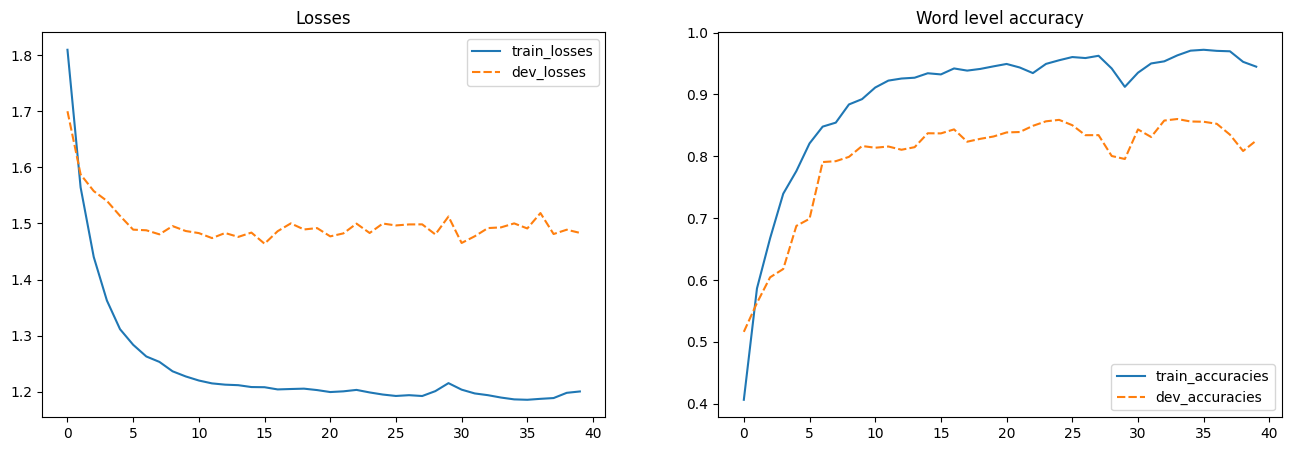

In [28]:
%%time
trainer = Trainer(
    model=model,
    train_loader=dl_train, 
    validation_loader=dl_dev,
    device=DEVICE
)

train_losses, train_metrics, dev_losses, dev_metrics = trainer.train(n_epochs=40, verbose=True)

<br><br><br><br><br><br>

## Task 5:
Write an evaluation loop on a trained model, using the dev and test datasets.   
This function will print a `RECALL-PERCISION-F1` scores and plot a `confusion matrix`.  

Do this twice: once for all the labels (7 labels in total), and once for all the labels except O (6 labels in total).   





Metrics:
- `Recall`: true positive rate (TPR), also known as Recall.
- `Percision`: the opposite to false positive rate (FPR), also known as precision.
- `F1 score`: harmonic average
- *For all these metries use **weighted**:
Calculate metrics for each label, and find their average weighted by support ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

To display:
1. Print a `RECALL-PERCISION-F1` scores in a `tabulate` format (similar to assignment#2)
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.


In [29]:
def evaluate(trainer, n_model, dataloader, dataset_name=None):
  title=f'{dataset_name} dataset Confusion Matrix' if dataset_name else None
  _, outputs = trainer.evaluate(dataloader, title=title)
  
  title = f'{dataset_name} dataset w/o \'O\' Confusion Matrix' if dataset_name else None
  _, outputs_wo_O = trainer.evaluate(dataloader, title=title, exclude_tag='O')

  model_configs = [n_model, trainer.model.hidden_size, trainer.model.n_layers, trainer.model.directions]
  total_results = [model_configs + [*outputs][1:] + [*outputs_wo_O][1:]]
  df_results = pd.DataFrame(total_results, columns=['N_MODEL', 'HIDDEN_SIZE','N_LAYERS','DIRECTIONS', 'PERCISION', 'RECALL','F1', 'PERCISION_WO_O', 'RECALL_WO_O','F1_WO_O'])
  return df_results

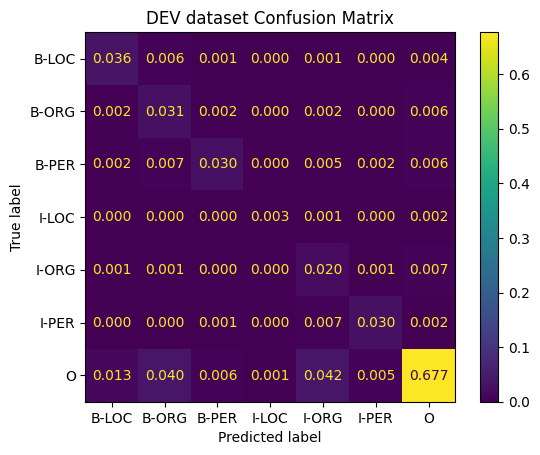

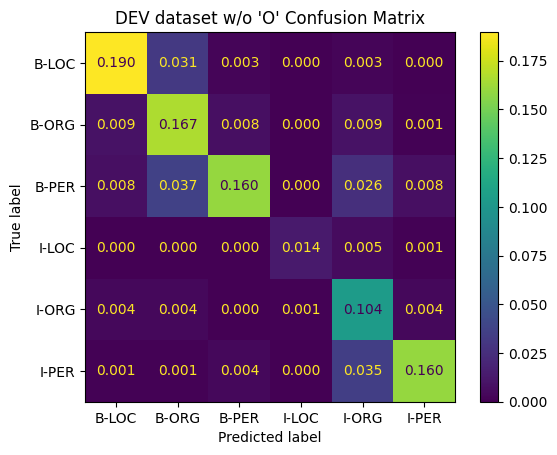

+----+-----------+---------------+------------+--------------+-------------+----------+----------+------------------+---------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   PERCISION |   RECALL |       F1 |   PERCISION_WO_O |   RECALL_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+-------------+----------+----------+------------------+---------------+-----------|
|  0 | Model1    |           500 |          1 |            2 |      0.8828 | 0.825514 | 0.845845 |         0.818844 |      0.691854 |  0.741695 |
+----+-----------+---------------+------------+--------------+-------------+----------+----------+------------------+---------------+-----------+


In [30]:
df_results = evaluate(trainer, 'Model1', dl_dev, 'DEV')
print(tabulate(df_results, headers='keys', tablefmt='psql'))

Note: look at part 6 for an example.
<br><br><br><br><br>

## Part 6



Reset all seeds to 42.

In [31]:
SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Train and evaluate a few models, all with `embedding_size=300`, and with the following hyper parameters (you may use that as captions for the models as well):

- Model 1: (hidden_size: 500, n_layers: 1, directions: 1)
- Model 2: (hidden_size: 500, n_layers: 2, directions: 1)
- Model 3: (hidden_size: 500, n_layers: 3, directions: 1)
- Model 4: (hidden_size: 500, n_layers: 1, directions: 2)
- Model 5: (hidden_size: 500, n_layers: 2, directions: 2)
- Model 6: (hidden_size: 500, n_layers: 3, directions: 2)
- Model 7: (hidden_size: 800, n_layers: 1, directions: 2)
- Model 8: (hidden_size: 800, n_layers: 2, directions: 2)
- Model 9: (hidden_size: 800, n_layers: 3, directions: 2)




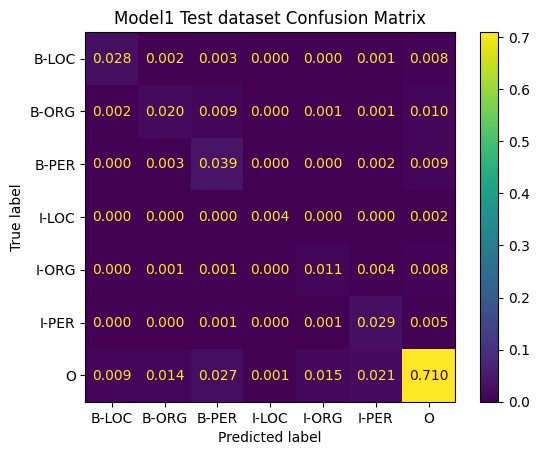

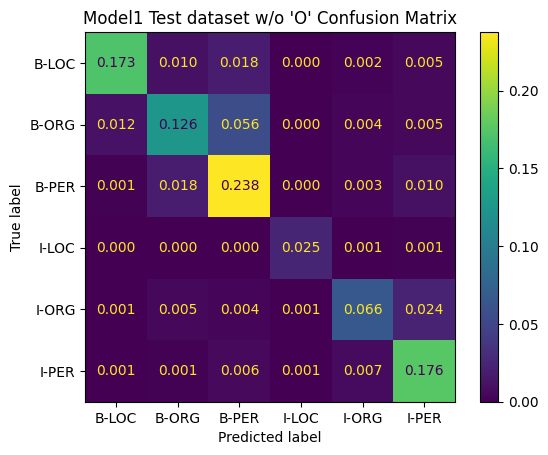

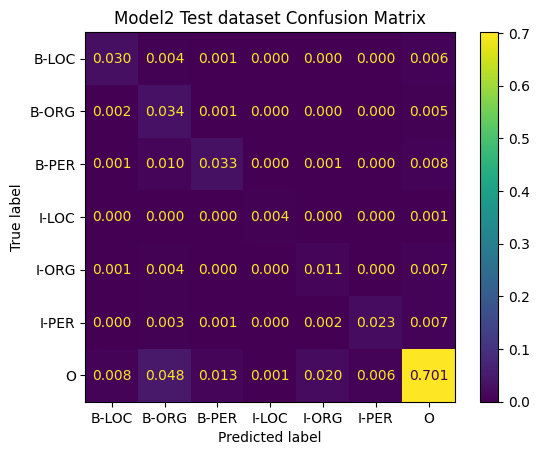

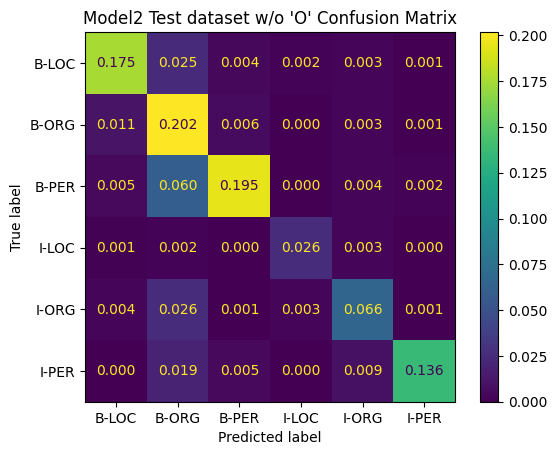

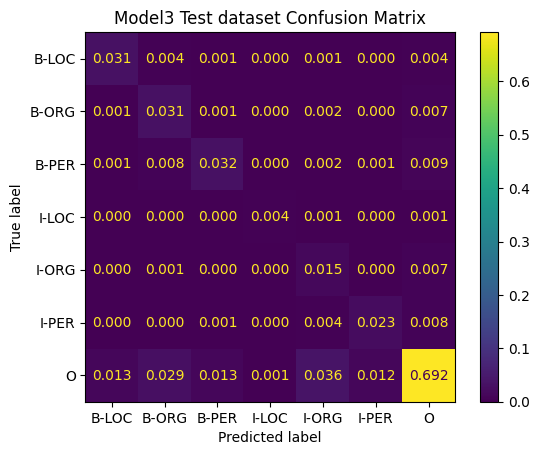

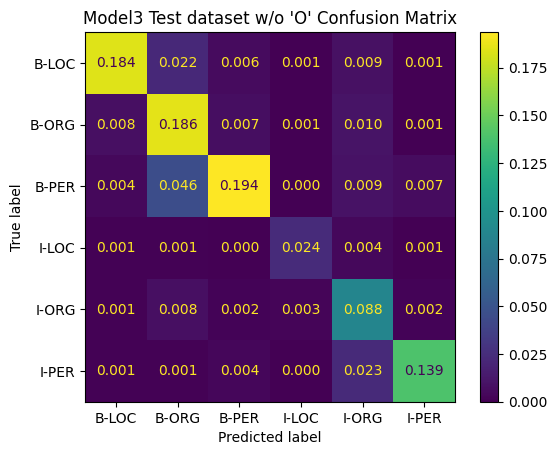

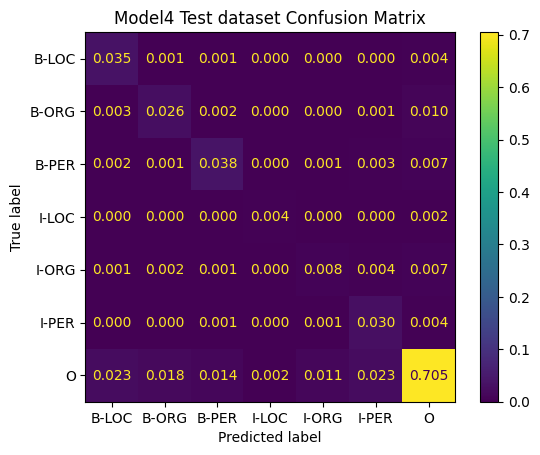

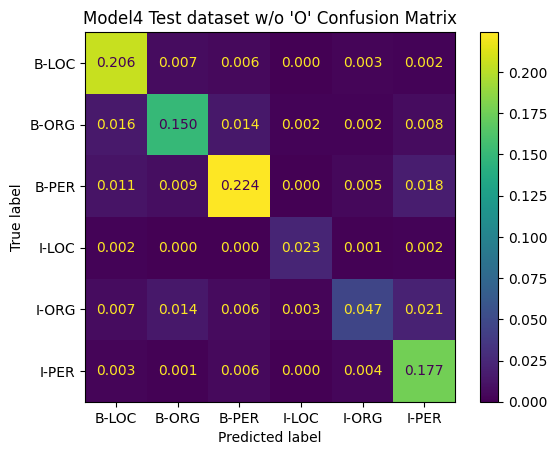

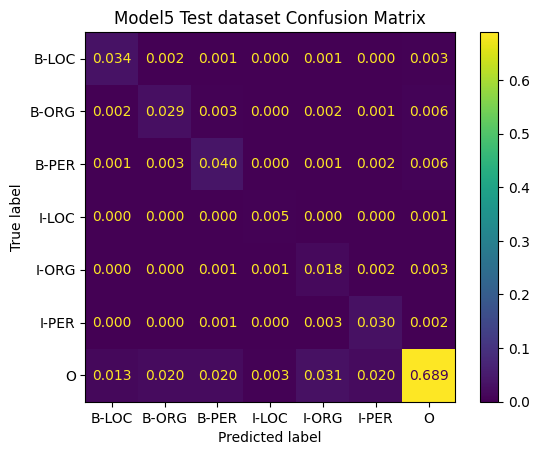

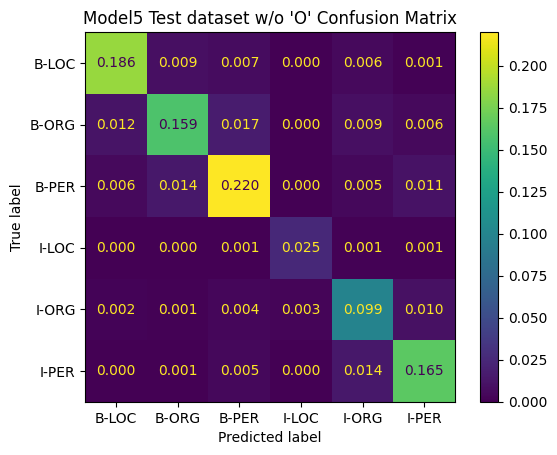

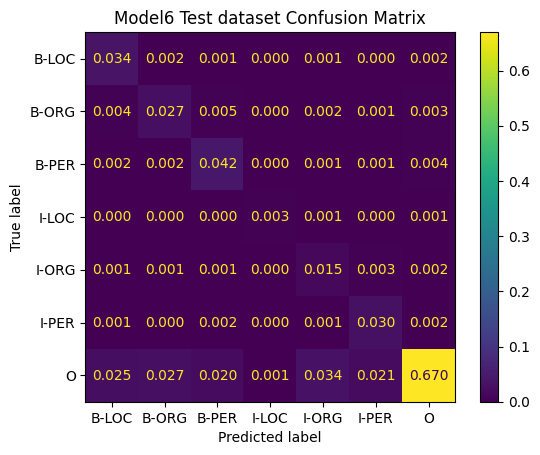

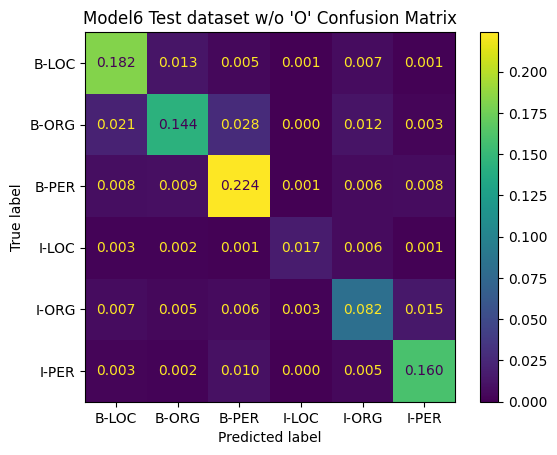

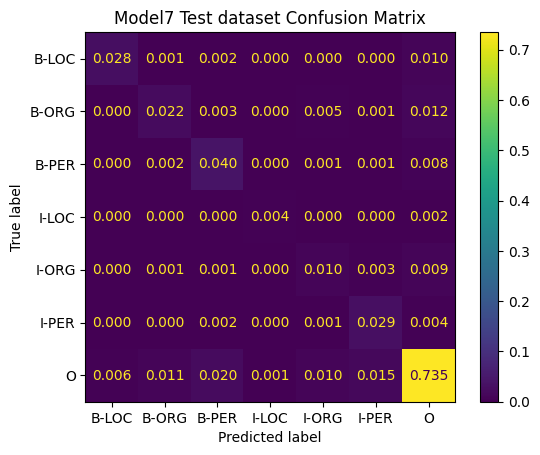

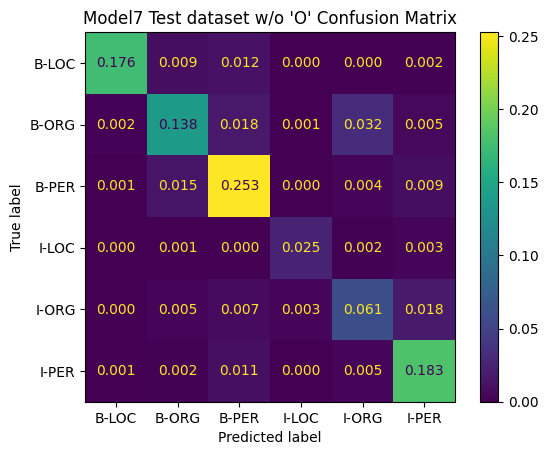

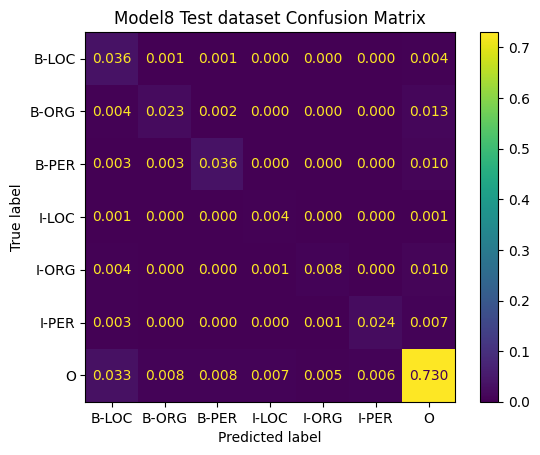

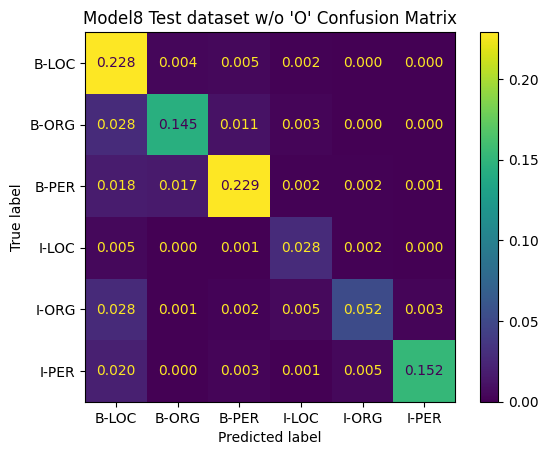

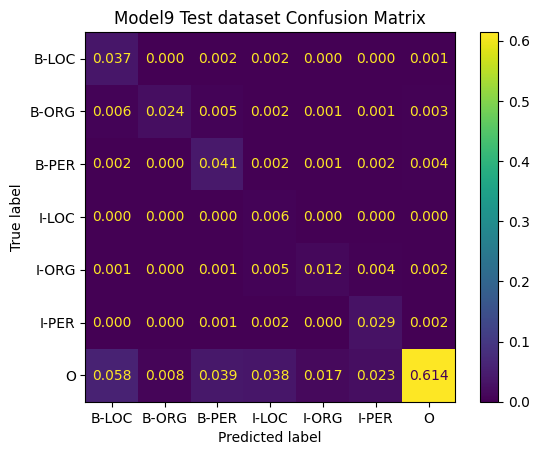

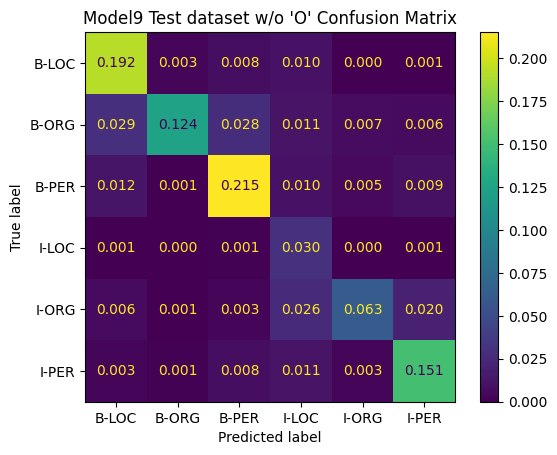

+----+-----------+---------------+------------+--------------+-------------+----------+----------+------------------+---------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   PERCISION |   RECALL |       F1 |   PERCISION_WO_O |   RECALL_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+-------------+----------+----------+------------------+---------------+-----------|
|  0 | Model1    |           500 |          1 |            1 |    0.86175  | 0.839743 | 0.847473 |         0.808053 |      0.640215 |  0.705426 |
|  1 | Model2    |           500 |          2 |            1 |    0.879437 | 0.836589 | 0.85202  |         0.836014 |      0.664678 |  0.727324 |
|  2 | Model3    |           500 |          3 |            1 |    0.870346 | 0.828461 | 0.844235 |         0.833596 |      0.670048 |  0.737502 |
|  3 | Model4    |           500 |          1 |            2 |    0.870832 | 0.84593  | 0.854052 |         0.824659 |      0

In [31]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','PERCISION','RECALL','F1','PERCISION_WO_O','RECALL_WO_O','F1_WO_O']
models = {
    'Model1': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model2': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model3': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model4': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model5': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model6': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model7': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model8': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model9': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}

df_results = pd.DataFrame(columns=columns)

for model_name, model_cnfg in models.items():
  model = NERNet(input_size=vocab.n_words+1, output_size=vocab.n_tags, **model_cnfg).to(DEVICE)
  
  trainer = Trainer(
    model=model,
    train_loader=dl_train, 
    validation_loader=dl_dev, 
    device=DEVICE
  )

  train_losses, train_metrics, dev_losses, dev_metrics = trainer.train(n_epochs=30)
  test_results = evaluate(trainer, model_name, dl_test, f'{model_name} Test')
  
  df_results = pd.concat([df_results, test_results], ignore_index=True, sort=False)

print(tabulate(df_results, headers='keys', tablefmt='psql'))


**Save CSV**  
In addition, for each model use the `test` dataset and check the model metrics. 

> Metrics:
1. `RECALL`, `PERCISION`,`F1` - for all tags
2. `RECALL_WO_O`,`PERCISION_WO_O`,`F1_WO_O` - for all tags **without** the O tag.
3. *For all these metries use **weighted** ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

> - Save the results in a CSV
`{student_id_1}_{student_id_n}_part6.csv`    
For example: `300123123_200456789_part_6.csv`

> - Print the results as follows:  (results here are random)

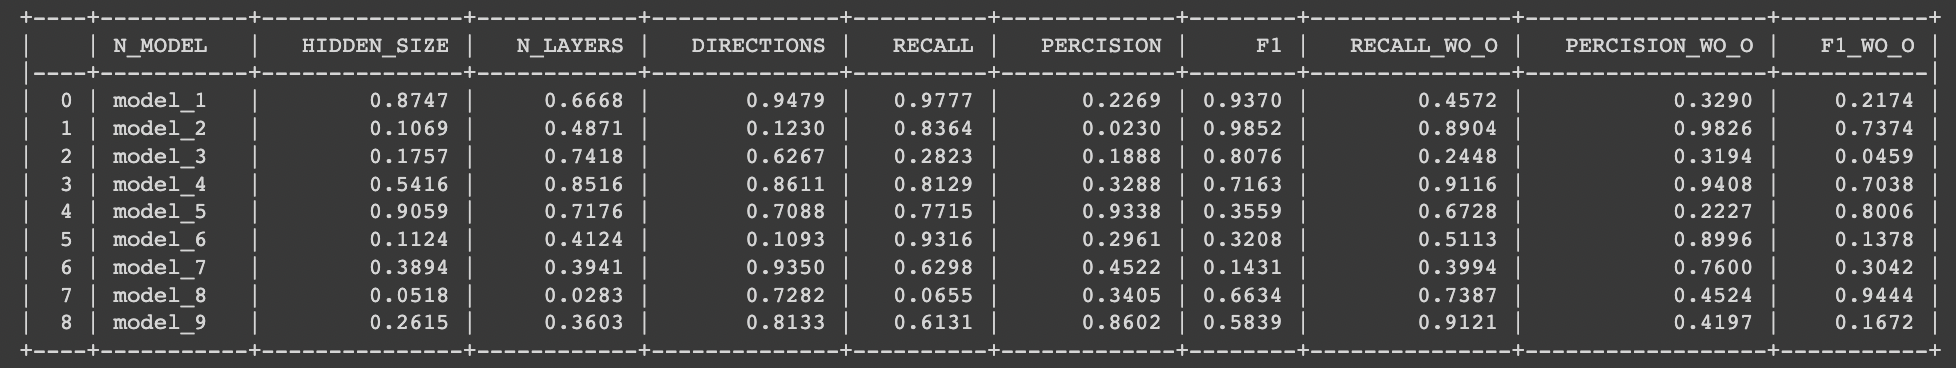

In [32]:
df_results.to_csv('201466349_313591851_part6.csv', index=False)

<br><br><br><br><br>

## Task 7: 

Reset all seeds to 42.

In [33]:
SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In preparation for this task you should read [this](https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222) dicussion.

*TIP: make sure that vectors are aligned with the IDs in your Vocab, in other words, make sure that for example the word with ID 0 is the first vector in the GloVe matrix of vectors that you initialize nn.Embedding with.*

---


Download the GloVe embeddings from https://nlp.stanford.edu/projects/glove/ (use the 300-dim vectors from glove.6B.zip). 


In [34]:
import torchtext

def generate_glove_embeddings():
  glove = torchtext.vocab.GloVe(name='6B', dim=300)
  OOV_ID = -1
  ids_from_glove = [OOV_ID]
  for _, word in vocab.id2word.items():
    glove_idx = glove.stoi.get(word.lower(), OOV_ID)
    ids_from_glove.append(glove_idx)
  
  ids_from_glove = np.array(ids_from_glove)

  vectors = glove.vectors[ids_from_glove]
  n_oov = np.count_nonzero(ids_from_glove == OOV_ID)
  vectors[ids_from_glove == OOV_ID] = torch.FloatTensor(np.random.randn(n_oov, 300))
  
  return nn.Embedding.from_pretrained(vectors, freeze=False)

Then intialize the `nn.Embedding` module in your `NERNet` with these embeddings, so that you can start your training with pre-trained vectors. 

In [35]:
embeddings = generate_glove_embeddings()
NERNet.from_pretrained_embeddings(
    embeddings=embeddings, 
    hidden_size=500, 
    output_size=vocab.n_tags, 
    n_layers=1, 
    directions=2
)

NERNet(
  (embedding): Embedding(7163, 300)
  (lstm): LSTM(300, 500, batch_first=True, bidirectional=True)
  (out): Sequential(
    (0): Linear(in_features=1000, out_features=7, bias=True)
    (1): Softmax(dim=-1)
  )
)

Repeat `Task 6`

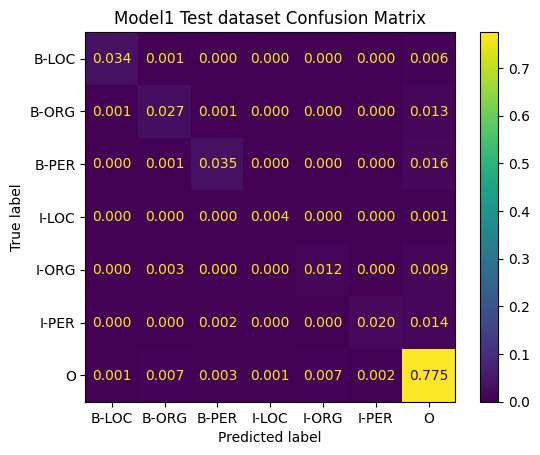

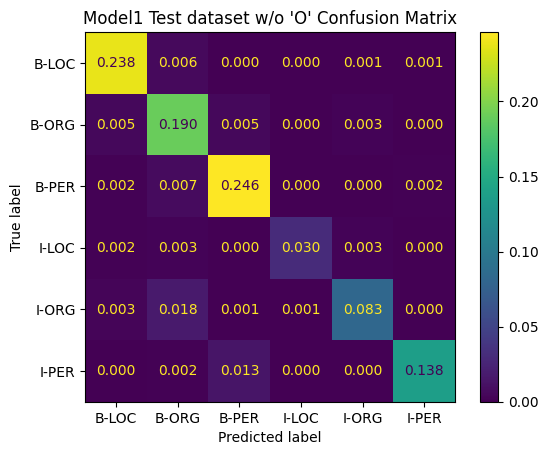

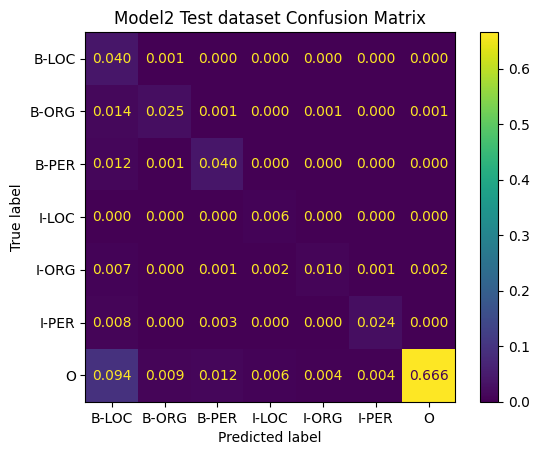

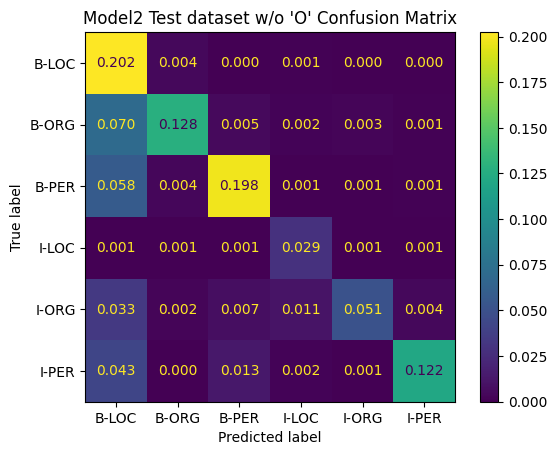

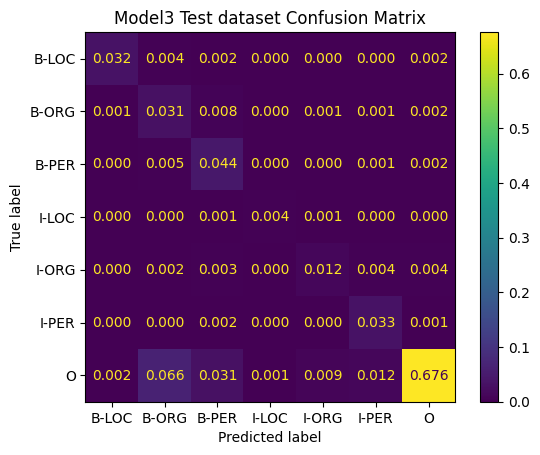

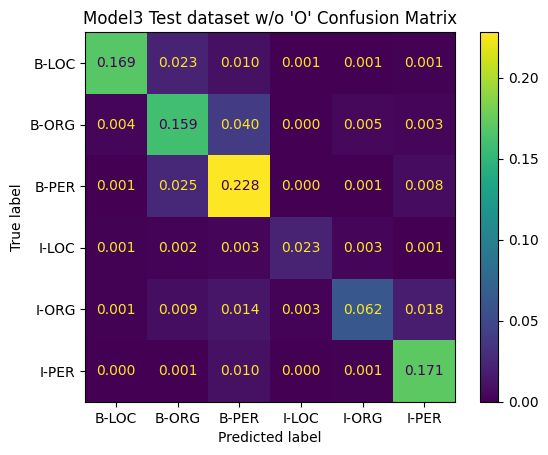

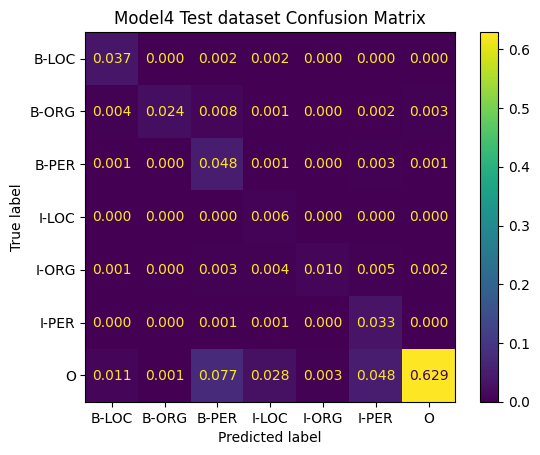

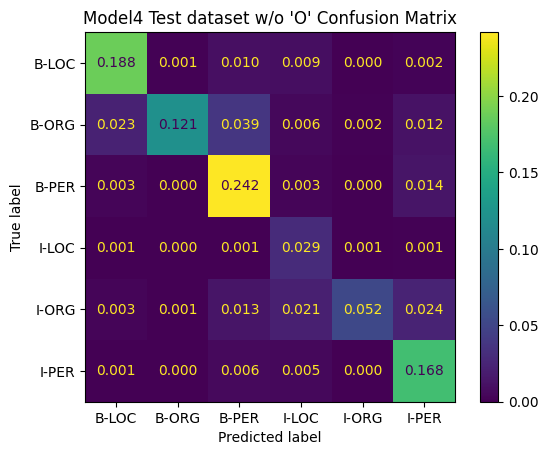

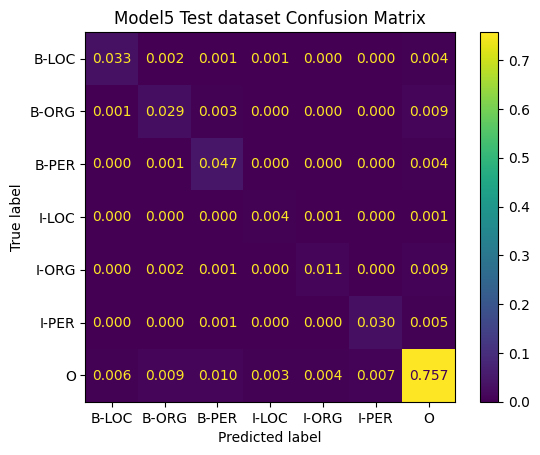

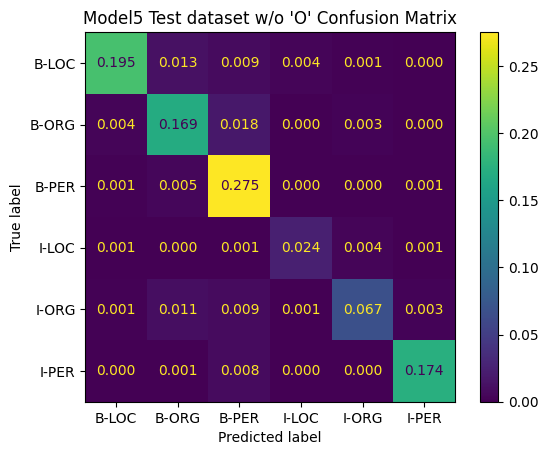

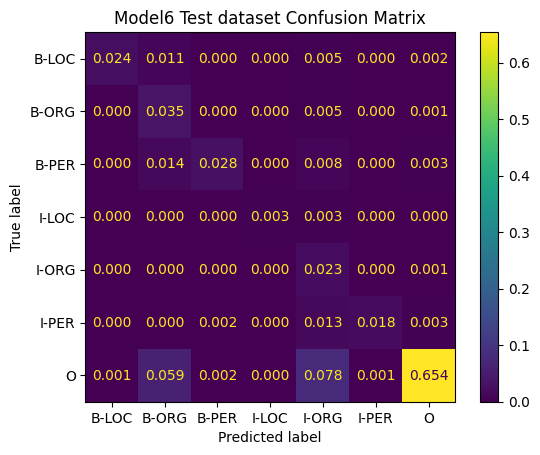

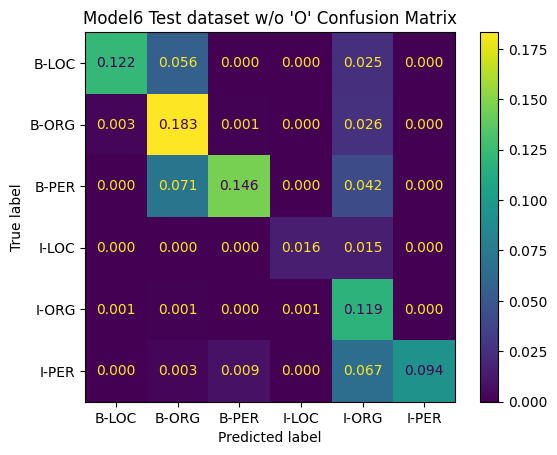

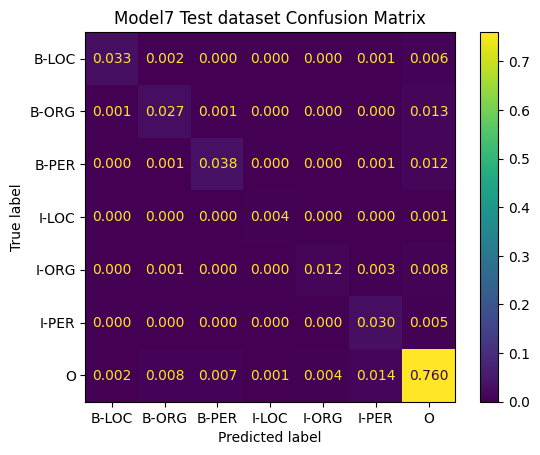

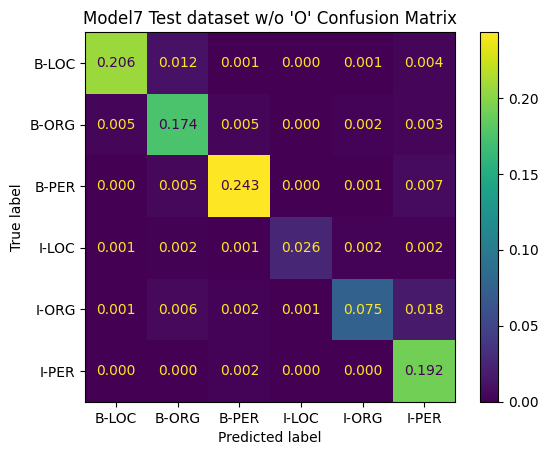

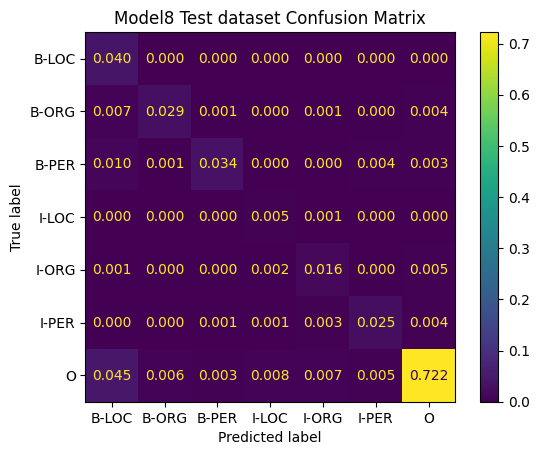

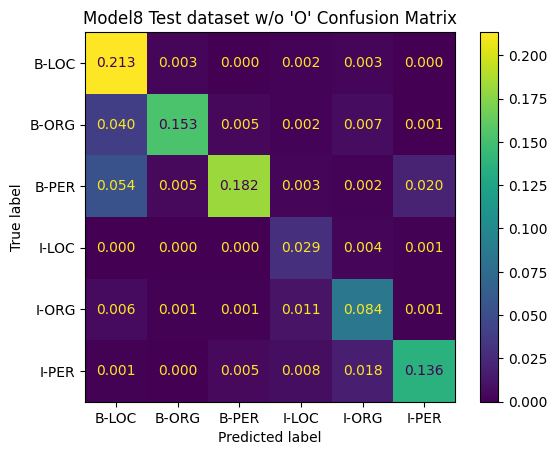

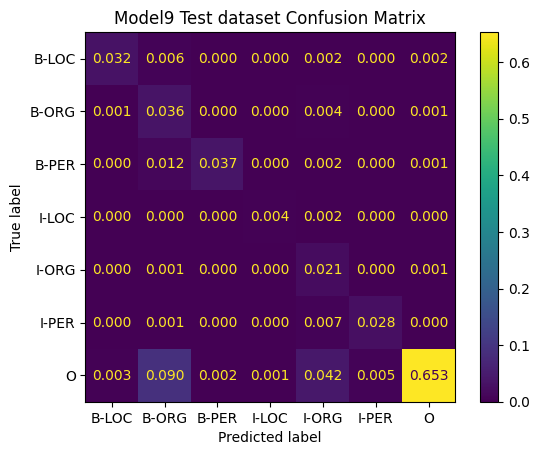

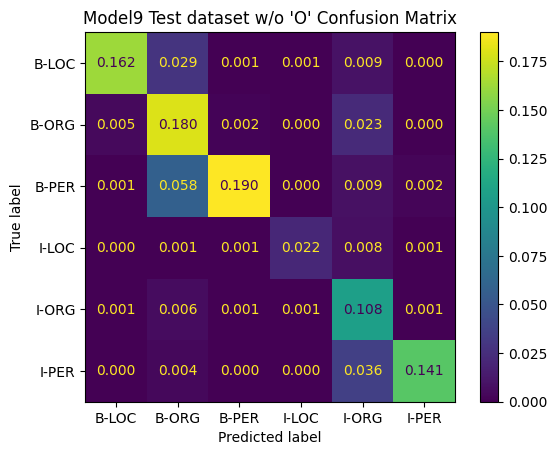

+----+-----------+---------------+------------+--------------+-------------+----------+----------+------------------+---------------+-----------+
|    | N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   PERCISION |   RECALL |       F1 |   PERCISION_WO_O |   RECALL_WO_O |   F1_WO_O |
|----+-----------+---------------+------------+--------------+-------------+----------+----------+------------------+---------------+-----------|
|  0 | Model1    |           500 |          1 |            1 |    0.904679 | 0.908407 | 0.903844 |         0.927242 |      0.654535 |  0.762192 |
|  1 | Model2    |           500 |          2 |            1 |    0.915115 | 0.811598 | 0.846605 |         0.818488 |      0.71599  |  0.727678 |
|  2 | Model3    |           500 |          3 |            1 |    0.899693 | 0.831615 | 0.854252 |         0.820431 |      0.76611  |  0.784352 |
|  3 | Model4    |           500 |          1 |            2 |    0.908994 | 0.787456 | 0.822527 |         0.844509 |      0

In [36]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','PERCISION','RECALL','F1','PERCISION_WO_O','RECALL_WO_O','F1_WO_O']
models = {
    'Model1': {'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model2': {'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model3': {'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model4': {'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model5': {'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model6': {'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model7': {'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model8': {'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model9': {'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}

df_results = pd.DataFrame(columns=columns)


for model_name, model_cnfg in models.items():
  glove_embeddings = generate_glove_embeddings()
  model = NERNet.from_pretrained_embeddings(
      output_size=vocab.n_tags,
      embeddings=glove_embeddings, **model_cnfg
    ).to(DEVICE)
  
  trainer = Trainer(
    model=model,
    train_loader=dl_train, 
    validation_loader=dl_dev, 
    device=DEVICE
  )

  train_losses, train_metrics, dev_losses, dev_metrics = trainer.train(n_epochs=20)
  test_results = evaluate(trainer, model_name, dl_test, f'{model_name} Test')
  
  df_results = pd.concat([df_results, test_results], ignore_index=True, sort=False)

print(tabulate(df_results, headers='keys', tablefmt='psql'))


Same as `Task 6`, please display:

1. Print a `RECALL-PERCISION-F1` scores in a tabulate format.
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.

- Save the results in a CSV {student_id_1}_{student_id_n}_part7.csv  
For example: 300123123_200456789_part_7.csv

- Print the results as follows:

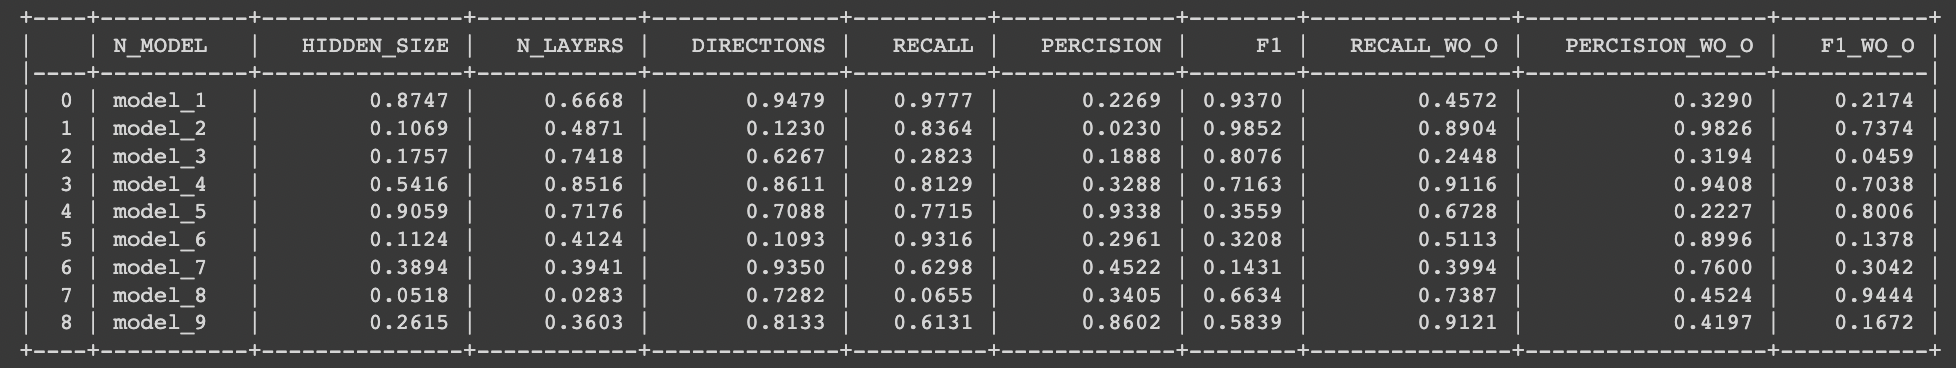

In [38]:
# TO DO
df_results.to_csv('201466349_313591851_part7.csv', index=False)

<br><br><br><br><br><br>
**Good luck!**